In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
DATASET = "./dataset/"
PLOT = "./plot.png"
MODEL = "./mask_detector.model"

INIT_LR = 0.0001
EPOCHS = 10
BATCH_SIZE= 32

In [3]:
print("***** loading images...  *****")
imagePaths = list(paths.list_images(DATASET))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)
print("***** Images loaded  *****")

***** loading images...  *****
***** Images loaded  *****


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


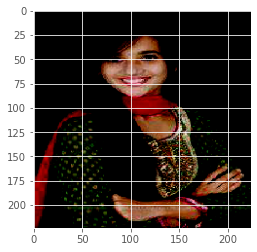

In [21]:
plt.imshow(data[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


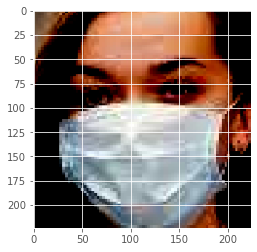

In [30]:
plt.imshow(data[3900])

In [4]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [5]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [6]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [7]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [8]:
print("***** compiling model...   *****")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("***** Model compiled   *****")

***** compiling model...   *****
***** Model compiled   *****


In [9]:
print("*****   training started...    *****")
H = model.fit(
     aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
     steps_per_epoch=len(trainX) // BATCH_SIZE,
     validation_data=(testX, testY),
     validation_steps=len(testX) // BATCH_SIZE,
     epochs=EPOCHS
)
print("*****   training completed.    *****")

*****   training started...    *****
Epoch 1/10
150/150 [==============================] - 226s 2s/step - loss: 0.2679 - accuracy: 0.8867 - val_loss: 0.0745 - val_accuracy: 0.9817
Epoch 2/10
150/150 [==============================] - 170s 1s/step - loss: 0.1047 - accuracy: 0.9663 - val_loss: 0.0494 - val_accuracy: 0.9875
Epoch 3/10
150/150 [==============================] - 171s 1s/step - loss: 0.0832 - accuracy: 0.9748 - val_loss: 0.0426 - val_accuracy: 0.9867
Epoch 4/10
150/150 [==============================] - 182s 1s/step - loss: 0.0649 - accuracy: 0.9800 - val_loss: 0.0355 - val_accuracy: 0.9900
Epoch 5/10
150/150 [==============================] - 170s 1s/step - loss: 0.0593 - accuracy: 0.9800 - val_loss: 0.0322 - val_accuracy: 0.9892
Epoch 6/10
150/150 [==============================] - 187s 1s/step - loss: 0.0514 - accuracy: 0.9829 - val_loss: 0.0300 - val_accuracy: 0.9908
Epoch 7/10
150/150 [==============================] - 201s 1s/step - loss: 0.0438 - accuracy: 0.9854 - va

In [10]:
print("*****   evaluating network    *****")
predIdxs = model.predict(testX, batch_size=BATCH_SIZE)
predIdxs = np.argmax(predIdxs, axis=1)

*****   evaluating network    *****


In [11]:
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

                        precision    recall  f1-score   support

   ./dataset/with_mask       0.99      0.99      0.99       600
./dataset/without_mask       0.99      0.99      0.99       601

              accuracy                           0.99      1201
             macro avg       0.99      0.99      0.99      1201
          weighted avg       0.99      0.99      0.99      1201



In [12]:
print("*****   saving mask detector model     *****")
model.save(MODEL, save_format="h5")

*****   saving mask detector model     *****


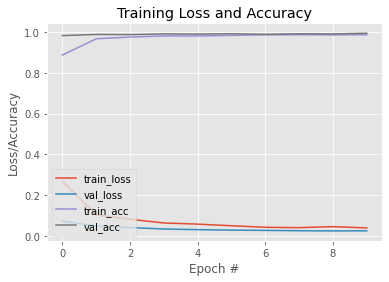

In [13]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(PLOT)